In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pickle as pkl
from matplotlib import style
import networkx as nx


from FormationControl import formation_control_force
from GradientEstimation import total_grad_est

style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

In [2]:
def circulant(i,q,p,prev,post,undirected=False):
    """
        Generate a circulant graph with len(p) nodes, node i connected with [i-prev:i+post],i-prev and i+post included but self-loop eliminated.
    """
    n = len(p)
    G = nx.DiGraph()
    edges = [(j%n,i) for i in range(n) for j in range(i-prev,i+post+1)]
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))
    if undirected:
        G = G.to_undirected()
    return G
def fc_comm_network(i,qs,ps):
    """
        Given the iteration number i, source location qs, sensor location ps,
        return the current communication network G.
        
        This variation returns a fully connected network with number of nodes=len(ps),
        without self-loops.
    """
    A = np.ones([len(ps),len(ps)])-np.eye(len(ps))
    return nx.from_numpy_matrix(A,create_using=nx.DiGraph)

## Distributed Version of Gradient Est., written in vectorized form.

In [3]:
class VirtualSensor:
    def __init__(self,C1,C0,k,b,noise_std = 0.01):
        self._C1 = C1
        self._C0 = C0
        self._k = k
        self._b = b
        self._sig = noise_std
        self._min_read = 1e-5

        
    def measurement(self,q,p):
        dists=np.linalg.norm(q-p,axis=1)
        
        y = self._k*(dists-self._C1)**self._b\
        +self._C0 + np.random.randn(dists.shape[0])*self._sig
        
        return np.max([self._min_read*np.ones(len(y)),y],axis=0)

# Distributed Sensor Movement Controller

In [4]:
class GradientEstimateController:
    
    def __init__(self,n_virtual_leaders,self_loc):
       
        self.vl_locs = None
        self.vl_vels = None
        
        self.loc = self_loc
        
        self.vel = np.zeros(self.loc.shape)
        
        alpha = 0.1 # The overall strength of the control force/potential
        k=1 # Determines how quickly the potential dies down to 0, in the order of 1/r^k.
        d0 = 0.8 # The equilibrium distance between sensors/virtual leaders.
        d1=100 # The distance above which the influence between sensors vanishes to 0.
        kD=0.2 # Dampening term on the sensor velocity, to achieve asymptotic stability.
        max_force=0.5 # A cap on the control force, to avoid pathological behavior.
        
        self.control_force = lambda robot_locs,robot_vels:formation_control_force(robot_locs,robot_vels,alpha,k,d0,d1,kD,max_force)

        self.max_vl_vel = 0.3

        self.min_vl_vel = 0.2
        
    def initialize_vl(self,initial_locs):
        CoM = np.mean(initial_locs,axis=0)

        ## Set up virtual leaders. Required for sensors' motion control.
        # Create a circular formation of virtual leaders centered at the CoM of mobile sensors, with one virtual leader at the CoM of the sensors.

        n_virtual_leaders = 1 # Only 1 virtual leader gives a much stabler formation than other # of virtual leaders.

        R0 = 0.8 # If there are more than 1 virtual leaders, this specifies the distance between them.

        if n_virtual_leaders>1:
            thetas = [2*np.pi/(n_virtual_leaders-1)*i for i in range(n_virtual_leaders-1)]
            self.vl_locs = np.vstack([CoM,CoM+ R0*np.array(np.vstack([np.cos(thetas),np.sin(thetas)]).T)])
        else:
            self.vl_locs = np.array([CoM])
        
        self.vl_vels = np.zeros(self.vl_locs.shape)
    
        
    def update(self,grad,neighbor_loc,neighbor_vel):
        
        if self.vl_locs is None:
            self.initialize_vl(np.vstack([self.loc,neighbor_loc]))
            
        grad_mag = np.linalg.norm(grad)

        if grad_mag>self.max_vl_vel: # Cap the magnitude of gradient update by max_vl_vel. This slows down the virtual leader and allows the sensors to stabilize.
            grad=grad/grad_mag * self.max_vl_vel
        elif grad_mag<self.min_vl_vel: # This keeps the virtual leader to move at a reasonable speed when the gradient is small.
            grad=grad/grad_mag * self.min_vl_vel
        
        self.vl_locs += grad
        
        vl_states = np.array([self.vl_locs,self.vl_vels])
        sensor_states = np.hstack([neighbor_loc,neighbor_vel])
        
        robot_locs = np.vstack([self.vl_locs,self.loc,neighbor_loc])
        robot_vels = np.vstack([self.vl_vels,self.vel,neighbor_vel])
        
        f = self.control_force(robot_locs,robot_vels)
        
        f_m = f[len(self.vl_locs)]
        
        self.vel -= f_m
        self.loc += self.vel

        return self.loc
        
        
  
        

In [ ]:
def get_adj_list(q,ps,G):
    a_list = []
    for i in G.nodes():
        a_list.append([k for k in G[i]])
    a_list = np.array(a_list)
    
    return a_list

N_iter = 100
N_trials = 100
C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
C0=0
k=1
b=-2


vs = VirtualSensor(C1,C0,k,b)


# for N_sen in [5,10,20,50]:

for N_sen in [40]:
    data = {'p':[],'q':[]}
    print('N_sen',N_sen)
    for k in range(N_trials):
        ps = np.random.rand(N_sen,2)
        vel = np.zeros(ps.shape)
        q = np.array([6,6])

        # Communication network
        comm_network_generator=lambda i,q,p:circulant(i,q,p,prev=1,post=0,undirected=True)
        # comm_network_generator=lambda i,q,p:fc_comm_network(i,q,p)
        G = comm_network_generator(0,q,ps)

        a_list = get_adj_list(q,ps,G)

        controllers = [GradientEstimateController(1,p) for p in ps]

        p_hist = []
        q_hist = []

        # Main loop
        for _ in range(N_iter):
            p_hist.append(ps.copy())

            y = vs.measurement(q,ps)

            gradient = total_grad_est(ps,y,G)

            for i,c in enumerate(controllers):
                c.update(gradient[i],\
                                 ps[a_list[i]],\
                                 vel[a_list[i]])
            ps = np.array([c.loc for c in controllers])
            vel = np.array([c.vel for c in controllers])
            q_hist.append(q)

        data['p'].append(np.array(p_hist))
        data['q'].append(np.array(q_hist))

    data['p'] = np.array(data['p'])
    data['q'] = np.array(data['q'])

    with open('Naomi-Distributed-{}Senor.pkl'.format(N_sen),'wb') as file:
        pkl.dump(data,file)

N_sen 40


<ipython-input-4-bb64f67aabc1>:54: RuntimeWarning: invalid value encountered in true_divide
  grad=grad/grad_mag * self.min_vl_vel


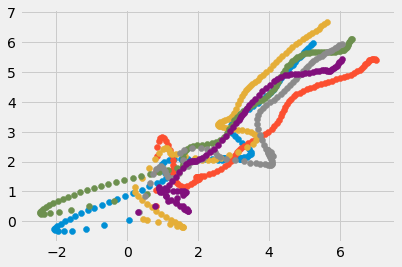

In [310]:
for i in range(N_sen):
    plt.scatter(p_hist[:,i,0],p_hist[:,i,1])